In [229]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, cohen_kappa_score
from IPython.display import HTML, display
import itertools
import seaborn as sns
import math

In [230]:
full_df = pd.read_csv("./llama/human_eval/svolgimenti/Svolgimenti_tutti.csv")

# remove extra quest
full_df = full_df.loc[full_df.Questionario != "human_eval_df1_5", :]

# sort data by questionary
full_df = full_df.sort_values(by="Questionario")

# answers to float
q_cols = [f"Domanda {i}" for i in range(1, 21)]
full_df.loc[:, q_cols] = full_df.loc[:, q_cols].applymap(
    lambda x: float(x.replace("Risposta ", "")) if type(x) == str else x
)

# indent signle missing value in human_eval_7b_ps_df1_3
quest_name = "human_eval_7b_ps_df1_3"
mean_val = full_df.set_index("Questionario").loc[quest_name, "Domanda 19"].mean()
mask = full_df.Questionario == quest_name
full_df.loc[mask, "Domanda 19"] = full_df.loc[mask, "Domanda 19"].fillna(mean_val)

full_df = full_df.reset_index(drop=True)
full_df = full_df.loc[full_df.Stato == "Completato", :]
full_df = full_df.loc[full_df.filter(regex="Domanda*").notna().all(axis=1), :]
full_df = full_df.loc[full_df.loc[:, "Domanda 7"] > 3, :]

/tmp/ipykernel_2434142/4202453964.py:11: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  full_df.loc[:, q_cols] = full_df.loc[:, q_cols].applymap(


In [231]:
mask_7b_pretrain = full_df.Questionario.str.contains("7b_ps")
mask_7b_finetune = ~mask_7b_pretrain
df_7b_pretrain = full_df.loc[mask_7b_pretrain, :].copy()
df_7b_pretrain.loc[:, "Questionario"] = (
    "./llama/human_eval/data/llama_7b_pretrained_shorter/" +
    df_7b_pretrain.loc[:, "Questionario"].str.replace("7b_ps_", "") +
    ".csv"
)
df_7b_finetune = full_df.loc[mask_7b_finetune, :].copy()
df_7b_finetune.loc[:, "Questionario"] = (
    "./llama/human_eval/data/llama_7b_fine_tuned_shorter/" +
    df_7b_finetune.loc[:, "Questionario"].str.replace("7b_ps_", "") +
    ".csv"
)

In [269]:
def normalize(x):
    return (x - x.mean()) / x.std()

def preprocess_df(df):
    background_dfs = [pd.read_csv(i, index_col=0) for i in df.Questionario.unique()]
    no_control_questions = []
    new_bkg_dfs = []
    for idx, background_df in enumerate(background_dfs):
        background_df.index = [f"Domanda {idx * 20 + i}" for i in range(1, 21)]
        no_control_questions.append([f"Domanda {idx * 20 + i}" for i in range(1, 21) if i != 7])
        background_df = background_df.loc[no_control_questions[idx], :]
        new_bkg_dfs.append(background_df)
    background_df = pd.concat(new_bkg_dfs, axis=0)

    _new_dfs = []
    _dfs = df.groupby("Questionario")
    _qs = []
    for idx, (q_name, _df) in enumerate(_dfs):
        _df = _df.filter(regex="Domanda*")
        _df = _df.rename({f"Domanda {i}": f"Domanda {idx * 20 + i}" for i in range(1, 21)}, axis=1)
        _df = _df.loc[:, no_control_questions[idx]]
        _df = _df.T
        _new_dfs.append(_df)
        for i in range(_df.shape[0]):
            _qs.append(q_name)
    _df = pd.concat(_new_dfs, axis=0)
    _df = pd.DataFrame([i[~np.isnan(i)][:5] for i in _df.values])
    _df.loc[:, "Questionario"] = _qs
    return _df, background_df

def get_metrics_df(_df, background_df):
    _metrics_df = pd.DataFrame()
    for col_idx, col in enumerate(_df.columns):
        if col == "Questionario":
            continue
        if _df.loc[:, col].notna().all():
            _metrics_df.loc[:, f"player {col_idx}"] = _df.loc[:, col].reset_index(drop=True)
    _metrics_df.loc[:, "avg_pred"] = _df.mean(axis=1, numeric_only=True).reset_index(drop=True)
    _metrics_df.loc[:, "bool_pred"] = _metrics_df["avg_pred"] <= 3
    _metrics_df.loc[:, "bool_scaled_pred"] = _metrics_df["avg_pred"] <= _metrics_df["avg_pred"].mean()
    _metrics_df.loc[:, "high_pred"] = _df.max(axis=1, numeric_only=True).reset_index(drop=True)
    _metrics_df.loc[:, "bool_high_pred"] = _metrics_df.high_pred <= 3
    _metrics_df.loc[:, "low_pred"] = _df.min(axis=1, numeric_only=True).reset_index(drop=True)
    _metrics_df.loc[:, "bool_low_pred"] = _metrics_df.low_pred <= 3
    _metrics_df.loc[:, "bool_is_human"] = background_df.is_human.reset_index(drop=True)
    _metrics_df.loc[:, "is_human"] = _metrics_df["bool_is_human"].apply(int)
    _metrics_df.loc[:, "missed"] = _metrics_df["bool_scaled_pred"] != _metrics_df["is_human"]
    _metrics_df.loc[:, "catched"] = _metrics_df["bool_scaled_pred"] == _metrics_df["is_human"]
    _metrics_df.loc[:, "Questionario"] = _df.loc[:, "Questionario"].values
    return _metrics_df

def compute_acc(metrics_df):
    return (
       np.round(accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_scaled_pred"]), 3) * 100,
       np.round(accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_pred"]), 3) * 100,
       np.round(accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_high_pred"]), 3) * 100,
       np.round(accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_low_pred"]), 3) * 100,
    )

def compute_all_acc(metrics_df):
    n_players = metrics_df.filter(regex="player*").shape[1]
    all_cohens = []
    players_scores = {}
    all_metrics_df = metrics_df.groupby("Questionario")
    for idx, (_, metrics_df) in enumerate(all_metrics_df):
        players_scores[f"quest_{idx}"] = {}
        quest_x = []
        for i in range(n_players):
            acc = np.round(
                accuracy_score(
                    metrics_df.loc[:, f"bool_is_human"],
                    metrics_df.loc[:, f"player {i}"] <= 3.0
                ),
                3
            ) * 100
            quest_x.append(acc)
            players_scores[f"quest_{idx}"][i] = {"acc": acc}
        all_data = np.zeros((n_players, n_players))
        for i, j in itertools.combinations(range(n_players), r=2):
            all_data[i,j] = cohen_kappa_score(
                metrics_df.loc[:, f"player {i}"] <= 3.0,
                metrics_df.loc[:, f"player {j}"] <= 3.0
            )
        all_cohens.append(all_data)
        players_scores[f"quest_{idx}"]["full_scores"] = compute_acc(metrics_df)
    return players_scores, all_cohens

In [270]:
processed_pretrain_df, background_pretrain_df = preprocess_df(df_7b_pretrain)
pretrain_metrics_df = get_metrics_df(processed_pretrain_df, background_pretrain_df)

processed_finetune_df, background_finetune_df = preprocess_df(df_7b_finetune)
finetune_metrics_df = get_metrics_df(processed_finetune_df, background_finetune_df)
processed_pretrain_df.shape

(95, 6)

global  (84.2, 84.2, 66.3, 61.1)
quest_0 (78.9, 73.7, 78.9, 57.9)
quest_1 (84.2, 78.9, 78.9, 52.6)
quest_2 (84.2, 89.5, 47.4, 57.9)
quest_3 (78.9, 84.2, 52.6, 68.4)
quest_4 (94.69999999999999, 94.69999999999999, 73.7, 68.4)


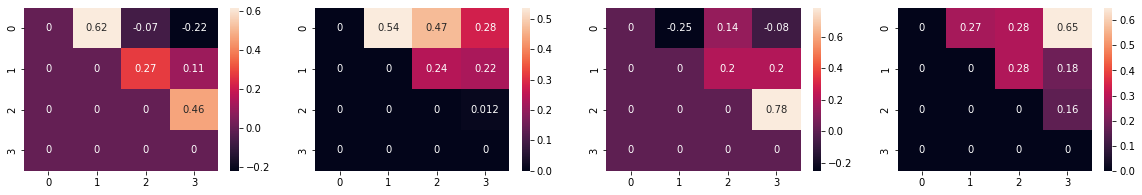

In [277]:
pretrain_players_scores, pretrain_all_cohens = compute_all_acc(pretrain_metrics_df)
print("global ", compute_acc(pretrain_metrics_df))
for key, val in pretrain_players_scores.items():
    print(key, val["full_scores"])
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
for i in range(4):
    sns.heatmap(
        pretrain_all_cohens[i],
        annot=True,
        ax=ax[i]
    )

global  (73.7, 69.5, 62.1, 55.800000000000004)
quest_0 (78.9, 68.4, 63.2, 52.6)
quest_1 (84.2, 84.2, 73.7, 63.2)
quest_2 (63.2, 47.4, 63.2, 52.6)
quest_3 (63.2, 73.7, 36.8, 57.9)
quest_4 (78.9, 73.7, 73.7, 52.6)


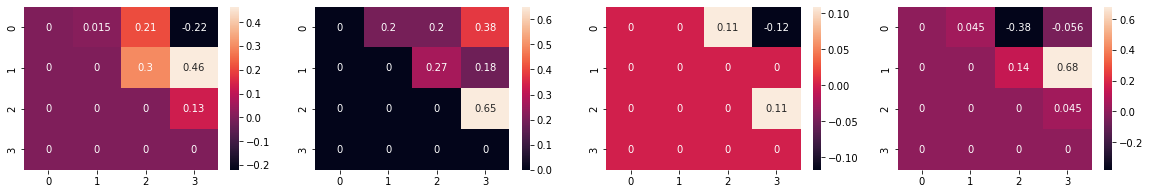

In [281]:
finetune_players_scores, finetune_all_cohens = compute_all_acc(finetune_metrics_df)
print("global ", compute_acc(finetune_metrics_df))
for key, val in finetune_players_scores.items():
    print(key, val["full_scores"])
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
for i in range(4):
    sns.heatmap(
        finetune_all_cohens[i],
        annot=True,
        ax=ax[i]
    )